In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input


In [ ]:


train_dir = r"/content/drive/MyDrive/KneeOA_dataset/train"
test_dir = r"/content/drive/MyDrive/KneeOA_dataset/test"
val_dir = r"/content/drive/MyDrive/KneeOA_dataset/val"


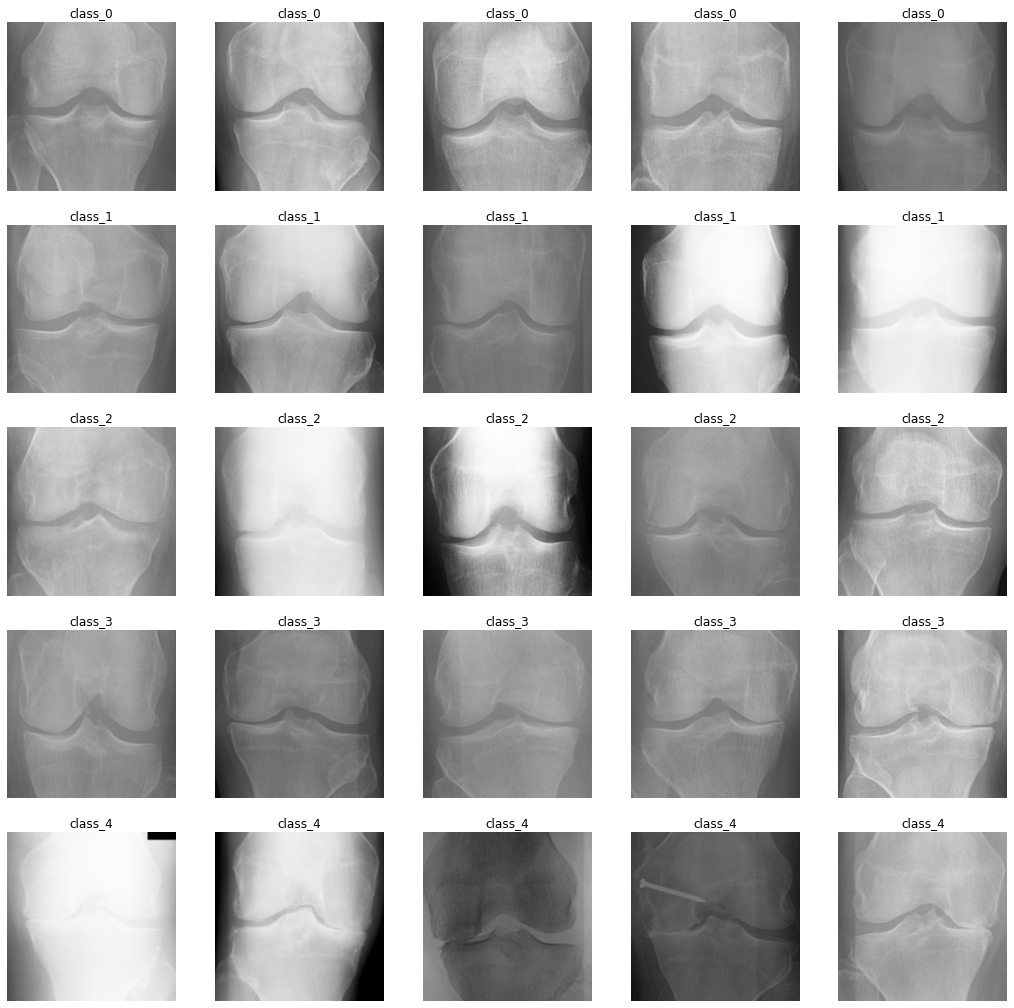

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(18,18))

for class_id in range(5):
    folder = os.path.join(train_dir,str(class_id))
    os.chdir(folder)
    samples = random.sample(os.listdir(folder), 5)

    for col in range(5):
        image = cv2.imread(samples[col])
        ax[class_id, col].imshow(image)
        ax[class_id, col].set_title("class_" + str(class_id))
        ax[class_id, col].set_axis_off()

plt.show()

In [ ]:
def show_distribution(folder):

    datagen = ImageDataGenerator()
    generator = datagen.flow_from_directory(folder)

    counter = Counter(generator.classes)
    total_images = sum(counter.values())
    distribution = [(class_id,round(num_images / total_images * 100,2)) for class_id, num_images in counter.items()]

    for class_id, percentage in distribution:
        print(class_id, percentage)

In [ ]:
print("The distribution for the training data is :\n")
show_distribution(train_dir)

The distribution for the training data is :

Found 5778 images belonging to 5 classes.
0 39.56
1 18.1
2 26.24
3 13.1
4 2.99


In [ ]:
print("The distribution for the validation data is :\n")
show_distribution(val_dir)

The distribution for the validation data is :

Found 826 images belonging to 5 classes.
0 39.71
1 18.52
2 25.67
3 12.83
4 3.27


In [ ]:
print("The distribution for the test data is :\n")
show_distribution(test_dir)

The distribution for the test data is :

Found 1656 images belonging to 5 classes.
0 38.59
1 17.87
2 26.99
3 13.47
4 3.08


In [ ]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_dir)

counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
print("\nThe class weights are : \n\n", class_weights)

Found 5778 images belonging to 5 classes.

The class weights are : 

 {0: 1.0, 1: 2.18546845124283, 2: 1.507915567282322, 3: 3.0198150594451785, 4: 13.213872832369942}


In [ ]:
folder = os.path.join(train_dir,'0')
os.chdir(folder)
samples = random.sample(os.listdir(folder), 5)

for filename in samples:
    image = cv2.imread(filename)
    print(image.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [ ]:
NUM_CLASSES = 5
IMAGE_SIZE=[224, 224]
BATCH_SIZE=32

In [ ]:
# Create the Generators
train_val_generator = ImageDataGenerator(
                                        preprocessing_function=preprocess_input,
                                        rotation_range=10,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='nearest'
                                        )

In [ ]:
# Train data generator
train_data = train_val_generator.flow_from_directory(train_dir,
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True
                                                    )

# Validation data generator
val_data = train_val_generator.flow_from_directory(val_dir,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  shuffle=True
                                                  )
# Test data generator
test_generator  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_generator.flow_from_directory(test_dir,
                                               target_size=IMAGE_SIZE,
                                               batch_size=1,
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               shuffle=False
                                               )

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.


**ResNet**

In [ ]:
base_model = ResNet152V2(input_shape=IMAGE_SIZE + [3],
                            include_top=False,
                            weights='imagenet',
                            pooling='avg'
                           )

for layer in base_model.layers:
    layer.trainable = False

234545216/234545216 [==============================] - 2s 0us/step


In [ ]:
x_input = base_model.input

x = Dense(128,activation='relu')(base_model.output)
x = Dropout(0.2)(x)

output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(x_input, output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
#verbose=1
hist = model.fit(train_data,
                 validation_data=val_data,
                 epochs=5,
                 callbacks=[reduce_lr, early_stopping],
                 )


Epoch 1/5
181/181 [==============================] - 3090s 17s/step - loss: 1.3575 - accuracy: 0.4124 - val_loss: 1.2368 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 2/5
181/181 [==============================] - 2966s 16s/step - loss: 1.2430 - accuracy: 0.4645 - val_loss: 1.2188 - val_accuracy: 0.4613 - lr: 0.0010
Epoch 3/5
181/181 [==============================] - 2880s 16s/step - loss: 1.2008 - accuracy: 0.4820 - val_loss: 1.1998 - val_accuracy: 0.4855 - lr: 0.0010
Epoch 4/5
181/181 [==============================] - 2910s 16s/step - loss: 1.1839 - accuracy: 0.4913 - val_loss: 1.2637 - val_accuracy: 0.4455 - lr: 0.0010
Epoch 5/5
181/181 [==============================] - 2937s 16s/step - loss: 1.1884 - accuracy: 0.4882 - val_loss: 1.1812 - val_accuracy: 0.4794 - lr: 0.0010


In [ ]:
model.evaluate(test_data)

1656/1656 [==============================] - 825s 498ms/step - loss: 1.1762 - accuracy: 0.4958


[1.1762423515319824, 0.49577295780181885]